# LSTM_model1

LSTM_model1 uses a simple layer of LSTM with N=100 times steps, Nh=150 hidden units.
Dataset can be downloaded in http://www.montefiore.ulg.ac.be/services/acous/STSI/downloads.php


In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""lstm for guitar signal"""
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
import scipy.io.wavfile
import time
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import *
from saveTransformedGraph import optimizeGraph

modelName = "LSTM_model1"

#############################
# Directory experiment
#############################
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("Experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("Experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)

# directory that will contain tensorboard information
pathLog = 'Tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.8
maxSize = 0
num_step = 100
num_hidden = 150
num_out = 1
num_feature = 1
batch_size = 1000
num_epoch = 10000                                      
trainDuration = 60*60*15                             
                                      
amplifierName = 'EnglDisto'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat' #dataset train/test path
fileNameTest = 'Datasets/test'+amplifierName+'.mat'     # dataset validation path
fileNameValidation = 'Datasets/val'+amplifierName+'.mat'

#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain = matrix['train']
matrix = sio.loadmat(fileNameTest)
matrixTest = matrix['test']
if maxSize ==0:
    maxSize = len(matrixTrain)
    print("maxSize = {}".format(maxSize))

train_input,train_output,test_input,test_output = loadInputOutputSeq(matrixTrain,matrixTest,num_step,maxSize)
print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")

#######################
# Graph Construction
#######################
G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data") 
        target = tf.placeholder(tf.float32, [None, num_out],name = "target")
        dataShaped = tf.reshape(data,[tf.shape(data)[0],tf.shape(data)[1],num_feature])
        dataShaped = tf.transpose(dataShaped,[1,0,2])
    
    with tf.name_scope("LSTMLayer"):
        fusedCell = tf.contrib.rnn.LSTMBlockFusedCell(num_hidden,use_peephole=False)
        val, state = fusedCell(dataShaped,dtype=tf.float32) 
        
    with tf.name_scope("extractLastCelloftheLSTMLayer"):
        last_index = tf.shape(val)[0] - 1
        lastState = tf.gather(val,last_index)
    
    prediction = fully_connected(lastState,int(target.get_shape()[1]),activation_fn=tf.nn.tanh,weights_regularizer=None,scope="FCPred")
    
##############################
# Cost function
##############################
    MSE = tf.reduce_mean(tf.square(prediction-target))
    EnergyTarget = tf.reduce_mean(tf.square(target)) 
    optimizer = tf.train.AdamOptimizer()
    minimize = optimizer.minimize(MSE)
    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    summary_op = tf.summary.merge_all()
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() 

##############################
# Graph execution
##############################
    
with tf.Session(graph=G) as sess:
    #restorePath = os.path.join('2017-09-11-18-07','temp','my_model.ckpt')
    #saver.restore(sess,restorePath)
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')
    
    no_of_batches = int(np.floor((numTrain)/batch_size)) 
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    NRMSETest = 1
    bestNRMSETest = 1    
    # train until the number of epochs or the training time is reached
    for epoch in range(num_epoch):
        tEpoch = time.clock()
        if (time.clock()-tStart < trainDuration) :
            ptr = 0
            if epoch % 20==0 : # each twenty epochs save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'myModel.ckpt'))
            
            pMSETrain=0
            pEnergyTarget=0
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                ptr+=batch_size
                
                if j % np.floor(numTrain/len(test_input)) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,summary_op,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
                    step = epoch*no_of_batches+j
                    # save the training RMSE for tensorboard
                    train_writer.add_summary(summary_str,step)                   

                else :
                    _,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
            # compute an estimation of the RMSE for this epoch       
            MSETrain = pMSETrain/no_of_batches
            EnergyTargetTrain = pEnergyTarget/no_of_batches
            NRMSETrain = np.sqrt(MSETrain/EnergyTargetTrain)
            print ("Epoch -{} calculated in {:5.2f} s ".format(epoch,time.clock()-tEpoch))
            # evaluate the model on the test set 
            pMSE = 0
            ptr2 = 0
            pEnergyTarget = 0
            for k in range(no_of_batchesTest):
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
            MSETest = pMSE/no_of_batchesTest
            EnergyTargetTest = pEnergyTarget/no_of_batchesTest
            NRMSETest = np.sqrt(MSETest/EnergyTargetTest)
            if NRMSETest<bestNRMSETest:
                bestNRMSETest=NRMSETest
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myBestGraph.pbtxt',as_text=True)
                save_path = saver.save(sess,os.path.join(pathTemp,'myBestModel.ckpt'))
            print("Epoch {}, NRMSE Test/best: {:.5f}/{:.5f}, Training NRMSE: {:.5f}, deviation of {:.2f}%".format(epoch,NRMSETest,bestNRMSETest,NRMSETrain,100*np.sqrt((NRMSETrain-NRMSETest)**2)/NRMSETrain))
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
    
    ################################################################
    # Save Graph variable and information about the running session
    ################################################################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pbtxt',as_text=True)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = bestNRMSETest
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = 1
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    infoLog["conv_chan"] = [0]
    infoLog["strides"] = 0
    infoLog["conv_size"] = 0
    infoLog["amplifierName"]=amplifierName
    logPerf(infoLog)
    input_nodes=["placeHolder/data"]
    output_nodes=["FCPred/Tanh"]
    optimizeGraph(pathTemp,input_nodes,output_nodes) 
    
    ################################################
    #   Validation
    ################################################
    restorePath = os.path.join(pathTemp,'myBestModel.ckpt') # restore the best model
    saver.restore(sess,restorePath)
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['val']  
    valSize = 0
    if valSize == 0 :
        valSize = len(matrixVal)
    # shape validation testpLast
    val_input,val_output = loadValidationSeq(matrixVal,num_step,valSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size
    #plt.show()scree
    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[6000+num_step:6700+num_step],label='prediction')
    ax.plot(targetArray[6000+num_step:6700+num_step],label='target')
    ax.legend()
    plt.xlabel('sample n')
    plt.ylabel('Amplitude y[n]')
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")


version 1.13.1 of tensorflow
maxSize = 6726407
shape input train (6726308, 100)
Data loaded
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch -0 calculated in 242.53 s 
Epoch 0, NRMSE Test/best: 0.87148/0.87148, Training NRMSE: 0.62956, deviation of 38.43%
Epoch -1 calculated in 242.70 s 
Epoch 1, NRMSE Test/best: 1.10016/0.87148, Training NRMSE: 0.50131, deviation of 119.45%
Epoch -2 calculated in 242.63 s 
Epoch 2, NRMSE Test/best: 0.98675/0.87148, Training NRMSE: 0.46363, deviation of 112.83%
Epoch -3 calculated in 242.59 s 
Epoch 3, NRMSE Test/best: 0.80054/0.80054, Training NRMSE: 0.42364, deviation of 88.97%
Epoch -4 calculated in 242.81 s 
Epoch 4, NRMSE Test/best: 1.01279/0.80054, Training NRMSE: 0.40830, deviation of 148.05%
Epoch -5 calculated in 242.60 s 
Epoch 5, NRMSE Test/best: 0.63509/0.63509, Training NRMSE: 0.40895, deviation of 55.30%
Epoch -6 calculated in 242.45 s 
Epoch 6, NRMSE Test/best: 0.60500/0.60500, Training NRMSE: 0.38948, deviation of 55.33%
Epoch -7 calculated in 243.09 s 
Epoch 7, NRMSE Test/best: 0.60895/0.60500, Training NRMSE: 0.38476, deviation of 58.27%
Epoch -8 calculated in 242.37

Epoch -67 calculated in 243.03 s 
Epoch 67, NRMSE Test/best: 0.72187/0.41931, Training NRMSE: 0.60376, deviation of 19.56%
Epoch -68 calculated in 242.39 s 
Epoch 68, NRMSE Test/best: 0.72730/0.41931, Training NRMSE: 0.60353, deviation of 20.51%
Epoch -69 calculated in 242.57 s 
Epoch 69, NRMSE Test/best: 0.75089/0.41931, Training NRMSE: 0.61306, deviation of 22.48%
Epoch -70 calculated in 242.57 s 
Epoch 70, NRMSE Test/best: 1.02971/0.41931, Training NRMSE: 0.73687, deviation of 39.74%
Epoch -71 calculated in 243.03 s 
Epoch 71, NRMSE Test/best: 1.05832/0.41931, Training NRMSE: 0.84260, deviation of 25.60%
Epoch -72 calculated in 242.65 s 
Epoch 72, NRMSE Test/best: 1.02834/0.41931, Training NRMSE: 0.90585, deviation of 13.52%
Epoch -73 calculated in 242.72 s 
Epoch 73, NRMSE Test/best: 1.04448/0.41931, Training NRMSE: 0.91688, deviation of 13.92%
Epoch -74 calculated in 242.23 s 
Epoch 74, NRMSE Test/best: 1.00425/0.41931, Training NRMSE: 0.91632, deviation of 9.60%
Epoch -75 calcula

Epoch 133, NRMSE Test/best: 0.72536/0.41931, Training NRMSE: 0.46018, deviation of 57.62%
Epoch -134 calculated in 242.60 s 
Epoch 134, NRMSE Test/best: 0.83364/0.41931, Training NRMSE: 0.45441, deviation of 83.46%
Epoch -135 calculated in 242.64 s 
Epoch 135, NRMSE Test/best: 0.70931/0.41931, Training NRMSE: 0.44300, deviation of 60.12%
Epoch -136 calculated in 242.87 s 
Epoch 136, NRMSE Test/best: 0.86425/0.41931, Training NRMSE: 0.47446, deviation of 82.16%
Epoch -137 calculated in 242.65 s 
Epoch 137, NRMSE Test/best: 0.80276/0.41931, Training NRMSE: 0.62824, deviation of 27.78%
Epoch -138 calculated in 242.73 s 
Epoch 138, NRMSE Test/best: 0.83694/0.41931, Training NRMSE: 0.50826, deviation of 64.67%
Epoch -139 calculated in 242.20 s 
Epoch 139, NRMSE Test/best: 0.65592/0.41931, Training NRMSE: 0.47362, deviation of 38.49%
Epoch -140 calculated in 242.80 s 
Epoch 140, NRMSE Test/best: 0.59719/0.41931, Training NRMSE: 0.45183, deviation of 32.17%
Epoch -141 calculated in 242.50 s 


Epoch -199 calculated in 242.40 s 
Epoch 199, NRMSE Test/best: 0.62548/0.41931, Training NRMSE: 0.39417, deviation of 58.68%
Epoch -200 calculated in 242.33 s 
Epoch 200, NRMSE Test/best: 0.91938/0.41931, Training NRMSE: 0.70433, deviation of 30.53%
Epoch -201 calculated in 242.61 s 
Epoch 201, NRMSE Test/best: 1.51050/0.41931, Training NRMSE: 0.76140, deviation of 98.39%
Epoch -202 calculated in 242.27 s 
Epoch 202, NRMSE Test/best: 1.31187/0.41931, Training NRMSE: 0.70689, deviation of 85.58%
Epoch -203 calculated in 242.36 s 
Epoch 203, NRMSE Test/best: 1.06214/0.41931, Training NRMSE: 0.68947, deviation of 54.05%
Epoch -204 calculated in 242.74 s 
Epoch 204, NRMSE Test/best: 1.45666/0.41931, Training NRMSE: 0.60948, deviation of 139.00%
Epoch -205 calculated in 242.46 s 
Epoch 205, NRMSE Test/best: 1.56185/0.41931, Training NRMSE: 0.73296, deviation of 113.09%
Epoch -206 calculated in 242.68 s 
Epoch 206, NRMSE Test/best: 1.11872/0.41931, Training NRMSE: 0.67360, deviation of 66.08

<IPython.core.display.Javascript object>


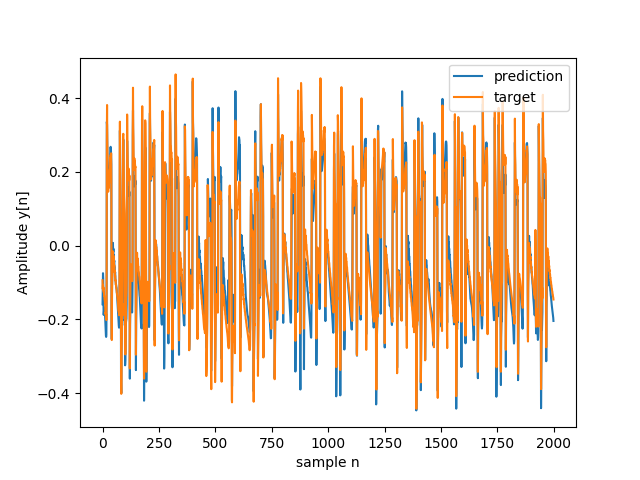

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)